# Lab 3

## Imports

In [478]:
from importlib import reload

In [479]:
import ARC_utilities
reload(ARC_utilities)

<module 'ARC_utilities' from '/mnt/c/Users/faust/OneDrive - UvA/teaching/ARC_course/arc-course/labs/ARC_utilities.py'>

In [598]:
from glob import glob
import json
from os import path
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import math
import matplotlib.gridspec as gridspec

import arckit
import arckit.vis as vis
from arckit.data import fmt_grid
import drawsvg

from ARC_utilities import plot_task, random_translate
from neural_utilities import extract_xml_answer, progress

from dotenv import load_dotenv, find_dotenv
import os
from openai import OpenAI

In [481]:
## copied from https://github.com/mxbi/arckit/issues/7

# Create a subclass of drawsvg.Group with a dummy embed_google_font method
class GroupWithFont(drawsvg.Group):
    def embed_google_font(self, *args, **kwargs):
        pass  # Do nothing

# Monkey-patch drawsvg in the arckit.vis module
vis.drawsvg.Group = GroupWithFont

In this notebook, we go through three things: 
1. Using the arckit library to display arc tasks (the examples in the repo's readme don't quite work).
2. Constructing a whole dataset from just a single task in a way that can be done at test time (what has been called 'active inference').
3. Using self-consistency prompting to improve accuracy - a good strategy for transduction.

Many more things would fit in this notebook, but as always time and energy are finite. I might add more if there's interest - let me know!

## Getting and manipulating the ARC tasks

We can get all the tasks in a nice format using the arckit library:

In [82]:
train_set, eval_set = arckit.load_data() 

Each task can be converted to a dictionary with keys 'test' and 'train', and with list of dictionaries are values. Each subdictionary has keys 'input' and 'output', and list of lists (representing the grids) as values. Here is an example:

In [87]:
eval_set.tasks[0].to_dict()

{'id': '00576224',
 'train': [{'input': [[8, 6], [6, 4]],
   'output': [[8, 6, 8, 6, 8, 6],
    [6, 4, 6, 4, 6, 4],
    [6, 8, 6, 8, 6, 8],
    [4, 6, 4, 6, 4, 6],
    [8, 6, 8, 6, 8, 6],
    [6, 4, 6, 4, 6, 4]]},
  {'input': [[7, 9], [4, 3]],
   'output': [[7, 9, 7, 9, 7, 9],
    [4, 3, 4, 3, 4, 3],
    [9, 7, 9, 7, 9, 7],
    [3, 4, 3, 4, 3, 4],
    [7, 9, 7, 9, 7, 9],
    [4, 3, 4, 3, 4, 3]]}],
 'test': [{'input': [[3, 2], [7, 8]],
   'output': [[3, 2, 3, 2, 3, 2],
    [7, 8, 7, 8, 7, 8],
    [2, 3, 2, 3, 2, 3],
    [8, 7, 8, 7, 8, 7],
    [3, 2, 3, 2, 3, 2],
    [7, 8, 7, 8, 7, 8]]}]}

We can also use the arckit library to plot the grids. First, we load a task:

In [106]:
task = arckit.load_single('007bbfb7')

In [108]:
task.train[0]

(array([[0, 7, 7],
        [7, 7, 7],
        [0, 7, 7]]),
 array([[0, 0, 0, 0, 7, 7, 0, 7, 7],
        [0, 0, 0, 7, 7, 7, 7, 7, 7],
        [0, 0, 0, 0, 7, 7, 0, 7, 7],
        [0, 7, 7, 0, 7, 7, 0, 7, 7],
        [7, 7, 7, 7, 7, 7, 7, 7, 7],
        [0, 7, 7, 0, 7, 7, 0, 7, 7],
        [0, 0, 0, 0, 7, 7, 0, 7, 7],
        [0, 0, 0, 7, 7, 7, 7, 7, 7],
        [0, 0, 0, 0, 7, 7, 0, 7, 7]]))

Then, we can plot a single grid: 

In [109]:
grid = vis.draw_grid(task.train[0][1], xmax=3, ymax=3, padding=.5, label='Example')

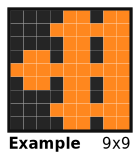

In [110]:
grid

Or plot a whole task at once (very neat little library!):

In [181]:
task = vis.draw_task(train_set[0], width=20, height=8, label='Example', include_test=True)

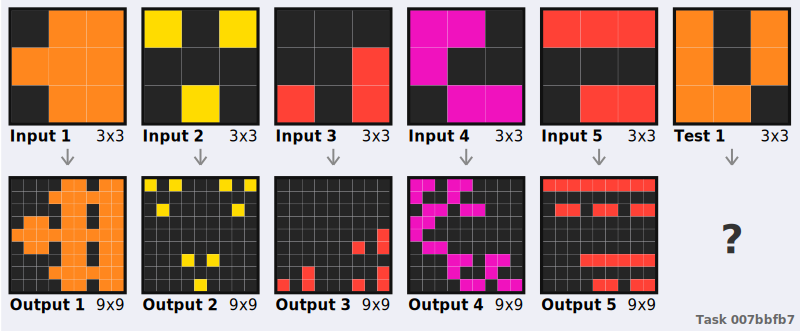

In [182]:
task

You can get more information about what you can do with this library on their [github page](https://github.com/mxbi/arckit).

The accuracy on a task is the mean test-wise success, where a test prediction is successful if it is identical to the one produced by the transformation for the corresponding input. In the evaluation set, there's only a handful of tasks with more than one test example; for those, task success can be != 1. or 0. Specifically, since they all have 2 test tasks, the accuracy can be 0.5.

In [76]:
arr = np.array([len(x['test']) for x in evaluation_data])

In [80]:
# print the number of examples for test tasks with more than one test example
arr[arr>1]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Active inference

Once we have a task, we can "cross-augment" it in various ways to get many more examples (this was done e.g., by Akyürek et al. - see Lecture 5 for more discussion of this). This has two advantages. First, more data can help us train the system better in general. Second, if we construct the augmented dataset using simply the transformation examples from the test task, we can do this at test time on the tasks in the private set. This is useful because the concepts involved in the private set tasks might be a bit different from the ones that we can see in the public set!

### Cross-augmentation

Cross-augmentation refers to the Leave-One-Out procedure of constructing alternative tasks by taking the examples, removing one, and treating it as a test case with a known solution, which can then be used for fine-tuning.

In [229]:
task = arckit.load_single('007bbfb7')

This can be done quite quickly as follows, generating as many new subtasks as there are input-output examples:

In [184]:
example

{'input': [[2, 2, 2], [0, 0, 0], [0, 2, 2]],
 'output': [[2, 2, 2, 2, 2, 2, 2, 2, 2],
  [0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 2, 2, 0, 2, 2, 0, 2, 2],
  [0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 2, 2, 2, 2, 2, 2],
  [0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 2, 2, 0, 2, 2]]}

In [230]:
train_task = task.to_dict()['train']
LOO_dataset = []
for i, example in enumerate(train_task):
    train = train_task[:i]+train_task[i+1:]
    LOO_dataset.append({
        'task': arckit.Task('example', train, [example]),
        'solution': example['output']
    })
    

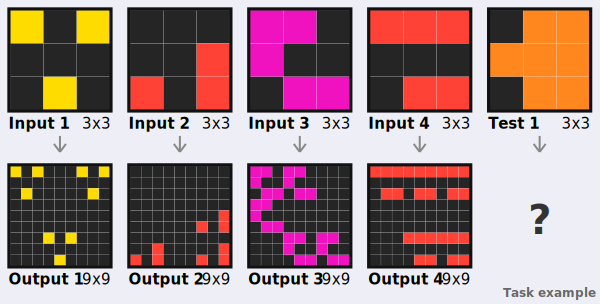

In [186]:
vis.draw_task(LOO_dataset[0]['task'], width=15, height=8, label='Example', include_test=True)

From here, you could collate each of these new subtasks into a 4-shot prompt with a known correct completion and use these prompts to fine tune an LLM on these additional problems, as we have done in the lab of module 4.

### Exploiting invariances

Something else that can be done to increase the training size at test time is to define a set of task-invariant transformations, which are likely to have the following property (given task-invariant transformation $T$, task solution $f$ and input $i$):

$$
\text{if } f(i) = o \text{, then } T(f(i)) = T(o)
$$

In other terms, we can generate a new example for the unknown task transformation by transforming both input and output in a known example. We can also compose the transformations and get even more transformations!

In [190]:
# let's take a single pair we're applying transformations on
pair = task.train[0]

In [502]:
apply_trans_to_pair = lambda t: lambda p: (t(p[0]), t(p[1]))

# let's take some of the transformations in Akyürek et al.
transformations = {
    'Rot_90':  lambda g: np.rot90(g, k=1),   # 90 degrees clockwise
    'Rot_180': lambda g: np.rot90(g, k=2),   # 180 degrees
    'Rot_270': lambda g: np.rot90(g, k=3),   # 270 degrees (or -90)
    'Flip_0': lambda g: np.flip(g, axis=1),
    'Flip_1': lambda g: np.flip(g, axis=0),
    'Refl_0r':  lambda g: np.concatenate((np.flip(g, axis=1), g), axis=0),
    'Refl_0': lambda g: np.concatenate((np.flip(g, axis=1), g), axis=1),
    'Refl_1r':  lambda g: np.concatenate((g, np.flip(g, axis=0)), axis=1),
    'Refl_1': lambda g: np.concatenate((np.flip(g, axis=0), g), axis=1),
    'RandTr_4': lambda g: random_translate(g, max_shift=4),
    'Transp': lambda g: g.T,
    'IncrWidth': lambda g: np.repeat(g, 2, axis=1),
    'IncrRes': lambda g: np.repeat(g, 2, axis=0),
}

In [656]:
# little drawing helper function
def draw_pair(pair, transformations):
    
    names = transformations.keys()
    transf = transformations.values()
    
    pairs = [
        apply_trans_to_pair(t)(pair)
        for t in transf
    ]
    drawing = vis.draw_task(
        arckit.Task(
            '', 
            [{'input': p[0], 'output': p[1]} for p in pairs], 
            []
        ), 
        width=40, 
        height=8,
    )
    drawing.extend( [
        drawsvg.Text(n, font_size=0.4,x=i*(drawing.width/len(names)) + 1,y=-drawing.height/50)
        for i,n in enumerate(names)
    ])
    drawing.height = 11
    return drawing

In [549]:
out = draw_pair(pair, transformations)

The basic thing to note here is that even without codifying the true task transformation, we are generating _new_ examples of it by applying out transformations to both inputs and outputs. While the fact that these new examples are also instances of the same transformation might be obvious to us, it may not be obvious to the system we are training. And those transformations that the system does not find obvious might be precisely the ones needed to generalize the test input: 

In [550]:
out.display_inline()

JupyterSvgInline(svg='<?xml version="1.0" encoding="UTF-8"?>\n<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"\n     width="1600.0" height="440" viewBox="0 0 40.0 9.399999999999999">\n<style>/*<![CDATA[*/@font-face {\n  font-family: \'Anuphan\';\n  font-style: normal;\n  font-weight: 400;\n  font-display: swap;\n  src: url(data:application/octet-stream;base64,AAEAAAAQAQAABAAAR0RFRgBEAEkAAAEcAAAAHEdQT1OK+nFxAAAGpAAADbBHU1VCmlyCGwAAAgQAAABcT1MvMgLWbbIAAAK8AAAAYFNUQVR4kWzdAAABnAAAAC5jbWFwAdwBiQAAAmAAAABcZ2FzcAAAABAAAAEUAAAACGdseWYgpib9AAAUVAAAFCBoZWFkHppi2QAAAcwAAAA2aGhlYQa0BywAAAF4AAAAJGhtdHiRCw4eAAADoAAAAQRsb2Nhm8GgrAAAAxwAAACEbWF4cABRAM8AAAE4AAAAIG5hbWUqaUmYAAAEpAAAAgBwb3N0/4YAPAAAAVgAAAAgcHJlcGgGjIUAAAEMAAAAB7gB/4WwBI0AAAEAAf//AA8AAQAAAAwAAAAAAAAAAgACAAEAIgABACQAMwABAAEAAABBAGoABwBjAAUAAQAAAAAAAAAAAAAAAAADAAEAAwAAAAAAAP+DADwAAAAAAAAAAAAAAAAAAAAAAAAAAAABAAAEAf7tAAAFGv3X/vwE2QPoAAAAAAAAAAAAAAAAAAAAQQABAAEACAABAAAAFAABAAAAHAACd2dodAEAAAAAAgADAAAAAgACAZAAAAK8AAAAAAABAAAAAwCDVLN7U18PPPUAAwPoAAAAANoc2isAAAAA4rRELf3X/rwE2QRfAAAABgACAAAAAAAAAAEAAAAKACoAOAADREZMVAAUbGF0bgAUdGhhaQAUAAQAAAAA//8AAQAAAAFsaWdhAAgAAAABAAAAAQAEAAQACAABAAgAAQASAAEACAABAAQANAACACUAAQABACAAAAACAAAAAwAAABQAAwABAAAAFAAEAEgAAAAOAAgAAgAGACAAOQA/AFoAaAB6//8AAAAgADAAPwBBAGEAav//AB8ABQAB/8D/uv+5AAEAAAAAAAAAAAAAAAAAAAAEAkoBkAAFAAACigJYAAAASwKKAlgAAAFeADwBVgAAAAAAAAAAAAAAAKEAAP9QAKB7AAAAAAAAAABOT05FAMAAIAB6BAH+7QAABF8BRCABAZMAAAAAAjoCugAAACAAAwAAABQALgBtAJoAvgDUAOgBIAE3AUwBbAGIAZcBtgHQAgQCKwJlApAC1ALlAwkDIANLA2gDfgOUA9YEDQQ3BG4EpQS/BTAFUwV3BZEFowXbBf0GKwZiBpkGtAb0BxEHNAdKB28HigepB78H5QgTCCkIVQiaCLYI7wkxCUUJlAnWCdYKEAHYACACgQAXAo0AXQJtADoCnwBdAkcAXQIvAF0CtwA6AsMAXQGQADwB/gAcAnoAXQH1AF0DLABdAsMAXQLEADoCXgBdAsQAOgKAAF0CRQAqAjwAFgKmAFgCYQAUA3sAFAJlABgCUQANAkQAJAIWACwCRABVAfcALwJEADICJQAvAUQAHQIQACsCOABVAPoAAQIPAFUBEABVA2kAVQI4AFUCMAAvAkQAVQJEADIBbwBVAecAJAFfAB0CNgBOAewAEgMAAB8B+wAVAfMAEQHQACECVAAdAlgAPAJYADMCWABFAlgAKgJYACYCWABNAlgAQwJYAEUCWAA6AlgAQwDsAAAB3QAXAAAACQByAAMAAQQJAAAApgDoAAMAAQQJAAEADgDaAAMAAQQJAAIADgDMAAMAAQQJAAMANACYAAMAAQQJAAQAHgB6AAMAAQQJAAUAGgBgAAMAAQQJAAYAHgBCAAMAAQQJAA4ANgAMAAMAAQQJAQAADAAAAFcAZQBpAGcAaAB0AGgAdAB0AHAAcwA6AC8ALwBvAHAAZQBuAGYAbwBuAHQAbABpAGMAZQBuAHMAZQAuAG8AcgBnAEEAbgB1AHAAaABhAG4ALQBSAGUAZwB1AGwAYQByAFYAZQByAHMAaQBvAG4AIAAzAC4AMAAwADIAQQBuAHUAcABoAGEAbgAgAFIAZQBnAHUAbABhAHIAMwAuADAAMAAyADsATgBPAE4ARQA7AEEAbgB1AHAAaABhAG4ALQBSAGUAZwB1AGwAYQByAFIAZQBnAHUAbABhAHIAQQBuAHUAcABoAGEAbgBDAG8AcAB5AHIAaQBnAGgAdAAgADIAMAAxADkAIABUAGgAZQAgAEEAbgB1AHAAaABhAG4AIABQAHIAbwBqAGUAYwB0ACAAQQB1AHQAaABvAHIAcwAgACgAaAB0AHQAcABzADoALwAvAGcAaQB0AGgAdQBiAC4AYwBvAG0ALwBjAGEAZABzAG8AbgBkAGUAbQBhAGsALwBBAG4AdQBwAGgAYQBuACkAAQAAAAoAJAAyAAJERkxUAA5sYXRuAA4ABAAAAAD//wABAAAAAWtlcm4ACAAAAAEAAAABAAQACQAIAAMM6gheAAwAAQACAAAACAACBywABAAAB+AHcgAjABoAAAAA//EADwAD//MAAAAAAAD/yf/xAAAAAAAAAAD/v//8AAAAAP/8//YAAAAAAAoABQAAAAAAAAAAAAgAAAAAAAAAAAAA/87/+wAAAAAAAAAA/7oAAAAAAAAAAP/9AAYAAAAAAAAAAAAA//YAAAAAAAAAAAAAAAAAAP/sAAAAAAAAAAAAAAAAAAD/9v/7AAAAAAAAAAAAAP/xAAAAAAAAAAAAAAAAAAAAAAAA//v/2P/7//YAAAAAAAD/uv/xAAAAAAAA//v/+wAA//sAAAAAAAAAAAAA//EAAAAAAAAAAAAA/+IAAAAAAAAAAAAA/+wAAAAAAAAAAAAA//IAAAAA//IAAAAAAAAAAAAAAAAAAAAAAAD/+//O//sAAAAAAAAAAP+6//EAAAAAAAD/+//7//r/+wAAAAAAAAAAAAD/8wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/9gAAAAUAAAAAAAD/8gAAAAAAAAAAAAAAAAAAAAAAAAAA/9gAAAAAAAAAAAAA/9MAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//sAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/5AAD/+wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/zv/4AAAAAAAAAAD/yf/sAAAAAAAA//sAAAAAAAAAAAAAAAD/zv/i/8n/zgAA/+L/2AAAAAD/5//q//YAAP/YAAUABf/O/8n/9v/sAAD/8f/s/9j/7AAA//sAAP/x//IAAAAAAAAAAP/nAAAAAAAAAAD//P/YAAD/+//iAAAAAAAAAAMAAP/lAAAAAAAA//MAAAAAAAAAAAAAAAD/+wAAAAAAAAAAAAAAAAAFAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA//YAAP/2AAAAAAAA//MAAwAAAAAAAAAAAAAAAAAAAAAAAAAA//oAAAAIAAAAAAAAAAAAAP/gAAAAAwAAAAAAAP/S//v/+v/8AAAAAAAGAAAAAAAFAAAAAAAAAAD//AAAAAAAAAAAAAD/2P/uAAAAAAAA//r/vwAAAAD/9v/5//cAAP/7//b/+wAAAAAAAAAAAAAAAAAAAAAAAAAA/94AAAAAAAAAAAAA/9r//QAAAAAAAAAAAAAAAAAAAAAAAAAA//b/4gAT////5P/2AAAAAP+2/9gAAAAAAAAA

If we want to also apply multiple transformations at once, we are going to need a function that takes a list of functions and composes them together:

In [208]:
def chain(*func_list):
    def chained(x):
        for f in reversed(func_list):
            x = f(x)
        return x
    return chained

For instance, we can compose the following $\mathbb{N} \to \mathbb{N}$ functions, to get $\lambda x: x*2 +1$:

In [402]:
f = chain(lambda x: x+1, lambda x: x*2)
print(f(1))

3


Now we can define some chained transformations:

In [554]:
# let's take some of the transformations in Akyürek et al.
composed_transformations = {
    # flipping -> rotating vs. rotating -> flipping
    'Flip0_Rot90': chain(transformations['Flip_0'], transformations['Rot_90']),
    'Rot90_Flip0': chain(transformations['Rot_90'], transformations['Flip_0']),
    # translate -> rotate vs. rotate -> translate
    'RandTr4_Rot90': chain(transformations['RandTr_4'], transformations['Rot_90']),
    'Rot90_RandTr4': chain(transformations['Rot_90'], transformations['RandTr_4']),
    # A three-function chain example
    'Rot90_Flip0_Transp': chain(transformations['Rot_90'], transformations['Flip_0'], transformations['Transp']),
    # sometimes order doesn't matter!
    'Refl0_IncrRes': chain(transformations['Refl_0'], transformations['IncrRes']),
    'IncrRes_Refl0': chain(transformations['IncrRes'], transformations['Refl_0']),
}

In [552]:
out = draw_pair(pair, composed_transformations)

/home/fausto/mambaforge/envs/arccourse/lib/python3.11/site-packages/arckit/vis.py:147: RuntimeWarning: divide by zero encountered in divide
  allocation[incr] += increment / incr.sum()


Note that the order of composition can matter, for instance if you flip and then rotate, you get a different result from first rotating and then flipping:

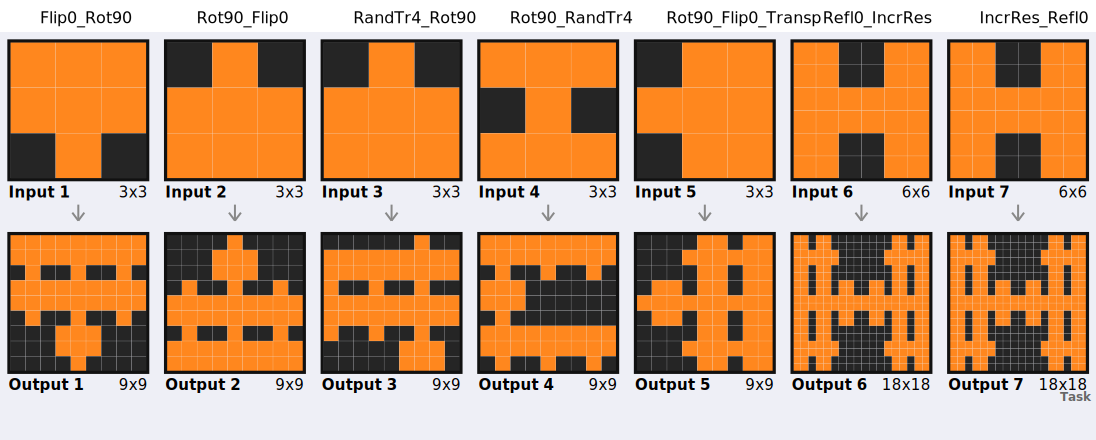

In [553]:
out

Can you hear the sound of [group theory](https://en.wikipedia.org/wiki/Group_theory) in the distance?

## Voting systems: self-consistency prompting

In [657]:
def get_prompt(task, i_test, spaces=True):
    """
    Based on Task.gpt_prompt
    """
    prompt = (
        "We are playing a game which involves transforming an input grid of digits into an output grid of digits. "
        "In general, digits form objects in 2D and the task is to perform some spatial transformation of these objects to go from the input grid to the output grid. "
        "All the information about the transformation is contained within the input pairs themselves, "
        "and your answer will only be correct if the output grid is exactly correct, so this is what I expect from you. "
        "\n\nPlease answer with the following format:\n"
        "<reasoning>\n...\n<\\reasoning>\n<answer>\nanswer grid\n<\\answer>\n\n"
        "I will begin by giving you several examples of input-output pairs. "
        "You will then be given a new input grid, and you must provide the corresponding output grid.\n\n"
    )
    
    i = 1
    for inp, output in task.train:
        prompt += f"Input {i}:\n{fmt_grid(inp, colour=False, spaces=spaces)}\nOutput {i}:\n{fmt_grid(output, colour=False, spaces=spaces)}\n\n"
        i += 1

    test_grid = task.test[i_test][0]
    prompt += f"Input {i}:\n"
    prompt += f"{fmt_grid(test_grid, colour=False, spaces=spaces)}"

    return prompt

In [663]:
def draw_pairs(pairs, names):
    drawing = vis.draw_task(
        arckit.Task(
            '', 
            [{'input': p[0], 'output': p[1]} for p in pairs], 
            []
        ), 
        width=40, 
        height=8,
    )
    drawing.extend( [
        drawsvg.Text(n, font_size=0.4,x=i*(drawing.width/len(names)),y=-drawing.height/50)
        for i,n in enumerate(names)
    ])
    drawing.height = 11
    return drawing

Let's implement the basic idea in Xuezhi Wang, Jason Wei, Dale Schuurmans, Quoc V Le, Ed H. Chi, Sharan Narang, Aakanksha Chowdhery, & Denny Zhou (2023). Self-Consistency Improves Chain of Thought Reasoning in Language Models. In The Eleventh International Conference on Learning Representations. Essentially we're gonna produce a bunch of samples with reasoning and an answer and then pick the answer that was given most often!

In [556]:
task = arckit.load_single('007bbfb7')

In [587]:
prompt = get_prompt(task, 0)

This is what a prompt would look like:

In [589]:
print(prompt)

We are playing a game which involves transforming an input grid of digits into an output grid of digits. In general, digits form objects in 2D and the task is to perform some spatial transformation of these objects to go from the input grid to the output grid. All the information about the transformation is contained within the input pairs themselves, and your answer will only be correct if the output grid is exactly correct, so this is what I expect from you. 

Please answer with the following format:
<reasoning>
...
<\reasoning>
<answer>
answer grid
<\answer>

I will begin by giving you several examples of input-output pairs. You will then be given a new input grid, and you must provide the corresponding output grid.

Input 1:
0 7 7
7 7 7
0 7 7
Output 1:
0 0 0 0 7 7 0 7 7
0 0 0 7 7 7 7 7 7
0 0 0 0 7 7 0 7 7
0 7 7 0 7 7 0 7 7
7 7 7 7 7 7 7 7 7
0 7 7 0 7 7 0 7 7
0 0 0 0 7 7 0 7 7
0 0 0 7 7 7 7 7 7
0 0 0 0 7 7 0 7 7

Input 2:
4 0 4
0 0 0
0 4 0
Output 2:
4 0 4 0 0 0 4 0 4
0 0 0 0 0 0 0 0

And let's ask gpt-4o to make some reasoned guesses:

In [625]:
n_samples = 30

confirmation = input("Running this will spend some $$. Do you want to run it anyway? (y/n): ").strip().lower()
if confirmation in ['y', 'yes']:
    
    _ = load_dotenv('../../../../.openAI_env')
    client = OpenAI(api_key=os.getenv('OPENAI-KEY'))

    # more expensive but better!
    model = "gpt-4o"
    # cheapest model!
    # model="gpt-4o-mini"
    
    openai_data = []
    out = display(progress(0, n_samples), display_id=True)
    for i in range(n_samples):
        completion = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}]
        )
        completion = completion.choices[0].message.content
        print(completion)
        openai_data.append({
            'completion': completion,
            'answer': extract_xml_answer(completion)
        })
        out.update(progress(i, n_samples))

    with open(f'./{model}_openaidata.csv', 'w') as openfile:
        json.dump(openai_data, openfile)

else:
    print("You: 'In *this* economy?'")

Running this will spend some $$. Do you want to run it anyway? (y/n):  y


<reasoning>
Analyzing the provided examples, it seems like the transformation follows a pattern where the input 3x3 grid is expanded into a 9x9 grid. Each cell in the input grid represents a 3x3 block in the output grid. The position of these blocks in the output follows a specific rule.

For a given digit in the input grid located at position (i, j), it will be represented by a 3x3 block located in specific positions of the 9x9 output grid based on (i, j). 

Specifically:
- For Input 1 to Output 1:
  - The "7" digits create a diagonal set of blocks in the output grid.
  
- In Input 2 to Output 2:
  - The "4" digits form a similar pattern but occupy different positions forming diagonal blocks in a new configuration.

- The presence of 0s seems to result in empty blocks in corresponding locations in the 9x9 grid.

Following this pattern, from Input 6:

Given the Input 6 grid:
7 0 7
7 0 7
7 7 0

We'll use this understanding to identify which blocks will be formed in the output:
- The top

I've already one this - let's just load the file:

In [604]:
with open(f'./{model}_openaidata.csv', 'rb') as openfile:
    openai_data = json.load(openfile)

And now let's count each time the model gave each answer:

In [628]:
unique, unique_counts = np.unique([x['answer'] for x in openai_data], return_counts=True)

In [639]:
formatted = []
for x, count in zip(unique, unique_counts):
    try:
        sub = []
        for y in x.split('\n')[:-1]:
            sub.append([int(j) for j in y.split()])
        formatted.append({'count': count, 'value': sub})
    except:
        print("didn't work")

didn't work
didn't work
didn't work


In [647]:
formatted

[{'count': 1,
  'value': [[7, 0, 7, 0, 0, 0, 7, 0, 7],
   [7, 0, 7, 0, 0, 0, 7, 0, 7],
   [7, 7, 0, 0, 0, 0, 0, 7, 0],
   [0, 0, 0, 7, 0, 7, 0, 0, 0],
   [0, 0, 0, 7, 0, 7, 0, 0, 0],
   [0, 0, 0, 7, 7, 0, 0, 0, 0],
   [7, 0, 7, 0, 0, 0, 7, 0, 7],
   [7, 0, 7, 0, 0, 0, 7, 0, 7],
   [7, 7, 0, 0, 0, 0, 0, 7, 0]]},
 {'count': 1,
  'value': [[7, 0, 7, 0, 0, 0, 7, 0, 7],
   [7, 0, 7, 0, 0, 0, 7, 0, 7],
   [7, 7, 0, 0, 0, 0, 7, 7, 0],
   [0, 0, 0, 7, 0, 7, 0, 0, 0],
   [0, 0, 0, 7, 0, 7, 0, 0, 0],
   [0, 0, 0, 7, 7, 0, 0, 0, 0],
   [0, 0, 0, 7, 0, 7, 7, 0, 0],
   [0, 0, 0, 7, 0, 7, 7, 0, 0],
   [0, 0, 0, 7, 7, 0, 0, 0, 0]]},
 {'count': 2,
  'value': [[7, 0, 7, 0, 0, 0, 7, 0, 7],
   [7, 0, 7, 0, 0, 0, 7, 0, 7],
   [7, 7, 0, 0, 0, 0, 7, 7, 0],
   [0, 0, 0, 7, 0, 7, 0, 0, 0],
   [0, 0, 0, 7, 0, 7, 0, 0, 0],
   [0, 0, 0, 7, 7, 0, 0, 0, 0],
   [7, 0, 7, 0, 0, 0, 7, 0, 7],
   [7, 0, 7, 0, 0, 0, 7, 0, 7],
   [7, 7, 0, 0, 0, 0, 7, 7, 0]]},
 {'count': 1,
  'value': [[7, 0, 7, 0, 0, 0, 7, 0, 7],
   [7,

In [666]:
len([f'Count: {x}' for x in unique_counts])

22

In [667]:
len([(task.test[0][0], x['value']) for x in formatted])

19

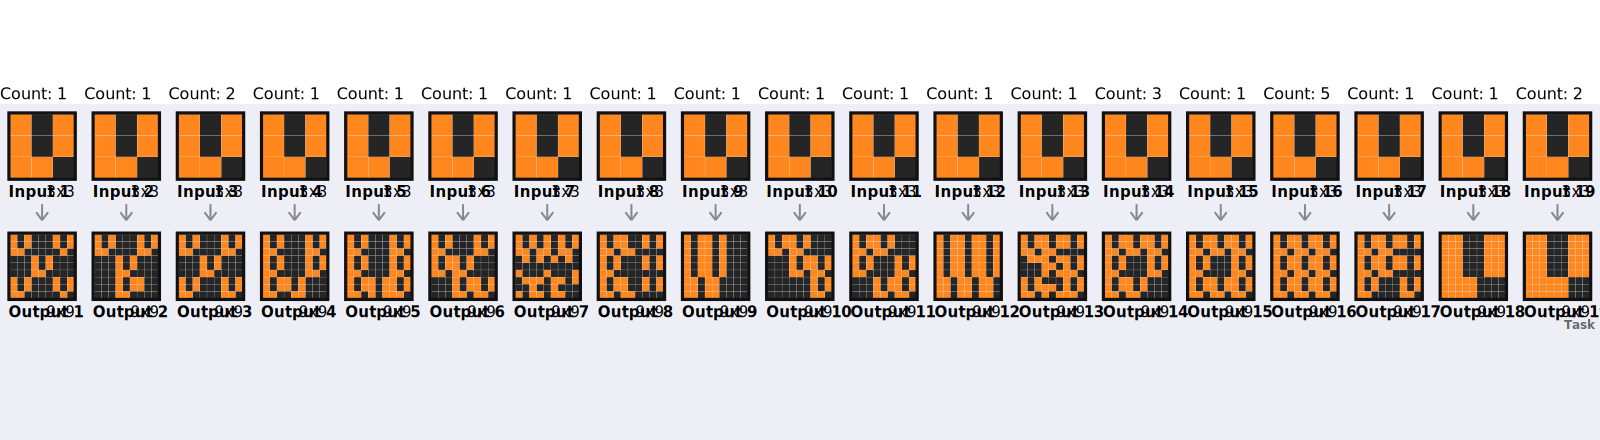

In [669]:
draw_pairs([(task.test[0][0], x['value']) for x in formatted], [f'Count: {x["count"]}' for x in formatted])

It didn't work out in this case, but that's how it works - Try it with other examples!